# 走神司机检测 PyTorch实现
本项目的数据来源是kaggle走神司机项目的[数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)。该数据集包含了10种类别的司机驾驶中的行为。为了简化处理，本项目已经将所有的数据下载并解压到跟本文件同目录，之后的所有操作建立在如下目录结构基础上：<br>
├── distracted_driver_detection.ipynb<br>
├── driver_imgs_list.csv<br>
└── imgs<br>
 &emsp;&emsp;├──test [79726 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── test<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp;└──train [22423 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c0 [2489 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c1 [2267 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c2 [2317 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c3 [2346 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c4 [2326 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c5 [2312 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c6 [2325 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c7 [2002 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;├── c8 [1911 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp; &emsp;&emsp;└── c9 [2129 images]<br>
 &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;├── ...jpg<br>
├── cache [.h5 files] <br>
└── subm [.csv file]<br>

In [41]:
from __future__ import print_function
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
import cv2
import matplotlib.pyplot as plt
import os
import glob
import time
import seaborn as sea
from sklearn.cross_validation import KFold
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 数据探索

In [2]:
# 读取csv
driver_image_lists = pd.read_csv('driver_imgs_list.csv')
driver_image_lists.tail()

,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [75]:
# 标签数组
classnames = list(set(driver_image_lists['classname']))
classnames.sort()
classnames

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

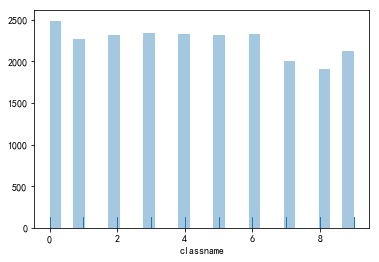

In [80]:
# 图片类别分布
classname_transfer = driver_image_lists['classname'].str[1:].astype('float32')
sea.distplot(classname_transfer,kde=False,rug=True)

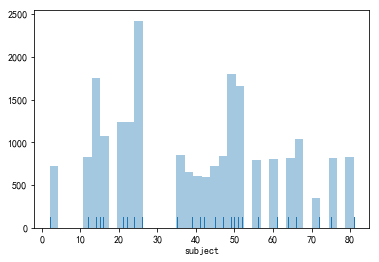

In [81]:
# 司机类别分布
subject_transfer = driver_image_lists['subject'].str[1:].astype('float32')
sea.distplot(subject_transfer,kde=False,rug=True)

In [3]:
# 根据unique_dirvers在driver_image_lists找到对应的img列表，
# 示例为{'subject1':['img1.jpg','img2.jpg','img3.jpg']}
def get_driver_img_map(driver_image_lists):
    # 司机id的集合
    unique_dirvers = list(set(driver_image_lists['subject']))
    driver_img_dict = {}
    for driver_id in unique_dirvers:
        img_list = driver_image_lists[driver_image_lists['subject']==driver_id]['img'].values.tolist()
        if driver_id in driver_img_dict:
            driver_img_dict[driver_id].extend(img_list)
        else:
            driver_img_dict[driver_id] = img_list
    return driver_img_dict

## 样本可视化

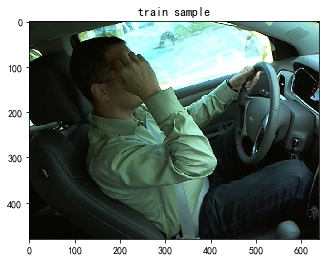

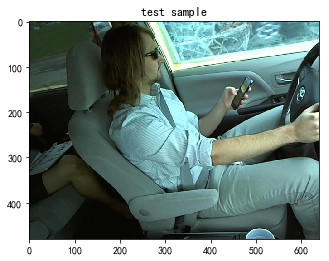

In [4]:
# 在训练集和测试集中分别选取一张图片进行展示
def show_sample(): 
    train_image_path = os.path.join('imgs','train','c0','*.jpg')
    test_image_path = os.path.join('imgs','test','test','*.jpg')
    train_files = glob.glob(train_image_path)
    test_files = glob.glob(test_image_path)
    train_file_index = 0
    test_file_index = 0
    for fl in train_files:
        if train_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('train sample')
            plt.show()
            break
    for fl in test_files:
        if test_file_index == 0:
            img = cv2.imread(fl)
            RGB_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(RGB_img)
            plt.title('test sample')
            plt.show()
            break
show_sample()

## 全局变量

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_image_dir = os.path.join('imgs','train')
test_image_dir = os.path.join('imgs','test')
use_cuda = torch.cuda.is_available()

## 超参数

In [4]:
DROPOUT_PROB = 0.5
N_EPOCHS = 20
BATCH_SIZE = 16
LR = 0.001
PIN_MEMORY=use_cuda # True IF CUDA

## 预处理与数据增强

In [5]:
transform_normal = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_aug = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## 自定义数据集
因为有交叉验证的需要，所以需要自定义数据集。

In [6]:
class SplitTrainingDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, split_img_list, tSet=False):
        self.img_path = img_path
        classnames = list(set(driver_image_lists['classname']))
        classnames.sort()
        self.class_names = classnames
        self.split_img_list = split_img_list
        self.tSet = tSet
        super(SplitTrainingDataset, self).__init__()
    
    def __len__(self):
        return len(self.split_img_list)
        
    def __getitem__(self, i):
        img_name = self.split_img_list[i]
        class_name = driver_image_lists[driver_image_lists['img']==img_name]['classname'].values[0]
        path = os.path.join(self.img_path,class_name,img_name)
        img = Image.open(path).convert('RGB')
        if self.tSet:
            self.transform = transform_aug
        else:
            self.transform = transform_normal
        img = self.transform(img)
        label = self.class_names.index(class_name)
        return img,label


## 查看部分图像

In [7]:
sample_img_list = ['img_89692.jpg','img_95056.jpg','img_96741.jpg','img_98917.jpg']
dataset1 = SplitTrainingDataset(train_image_dir, sample_img_list, True)

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

# 这里如果num_workers大于0，会卡死，不知道为什么？

In [ ]:
dataloader1 = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=1,pin_memory=PIN_MEMORY)
image,label = next(iter(dataloader1))

In [9]:
dataloader2 = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=0,pin_memory=PIN_MEMORY)

In [10]:
image,label = next(iter(dataloader2))
image.numpy()[0].shape

(3, 224, 224)

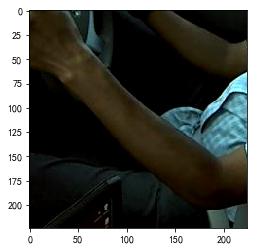

In [11]:
imshow(image[0])

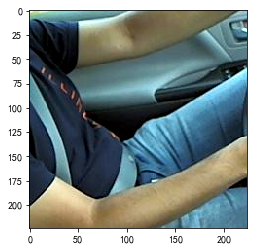

In [13]:
image,label = next(iter(dataloader2))
imshow(image[0])

## Finetuning 模型

In [32]:
model_ft = models.vgg13_bn(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

In [23]:
model_ft.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

In [19]:
model_ft.classifier[-1] = nn.Linear(4096, 10)
model_ft.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [20]:
model_ft.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Con

In [37]:
for p in model_ft.classifier.parameters():
    print(p.size())

torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([1000, 4096])
torch.Size([1000])


In [42]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 模型训练

In [ ]:
def train_model(model, criterion, optimizer, sheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.stat_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        

## 模型集成

In [ ]:
def kfold_split_and_train(unique_dirver_ids=get_driver_img_map(), img_path=train_image_dir, k=10):
    kf = KFold(len(unique_dirver_ids), n_folds=k, shuffle=True, random_state=51)
    num_fold = 0
    for train_driver_ids, valid_driver_ids in kf:
        num_fold += 1
        # 根据id在driver_image_lists中找对应的文件名
        train_img_name_list = []
        valid_img_name_list = []
        for id in train_driver_ids:
            train_img_name_list.extend(driver_img_dict[id])
        for id in valid_driver_ids:
            valid_img_name_list.extend(driver_img_dict[id])
            
        train_dataset = SplitTrainingDataset(img_path, train_img_name_list, True)
        valid_dataset = SplitTrainingDataset(img_path, valid_img_name_list)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=1)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                                                  shuffle=True, num_workers=1)
        # 载入模型
        
        # 训练并保存最优模型
        
        # 先训练一个分类器
        if num_fold == 1:
            break

### 训练、验证模型